# empymod inversion using SciPy and the SimPEG-Regularization

Example provided by Wouter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import empymod
from discretize import TensorMesh
from SimPEG import regularization
from scipy.optimize import minimize

## Defining the Model and Mapping

Here we generate a synthetic model and a mappig which goes from the model space to the row space of our linear operator.

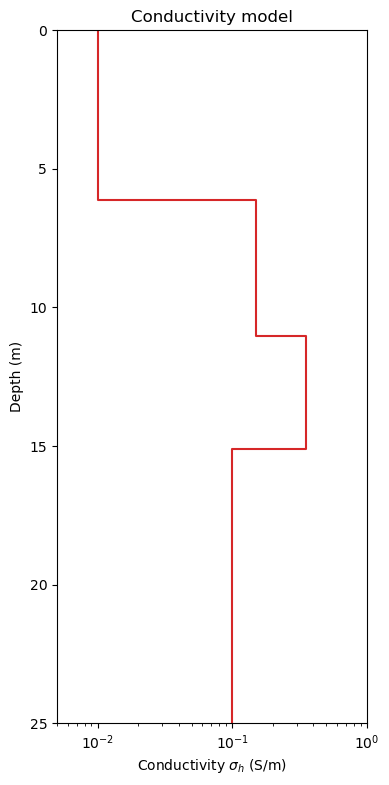

In [2]:
nParam = 50  # Number of model parameters

depth = np.linspace(0, 20, nParam)
# A 1D mesh
mesh = TensorMesh([np.r_[np.diff(depth),1]])

# Creating the true model
true_model = np.ones(nParam)*0.01
true_model[depth > 6] = 0.15
true_model[depth > 11] = 0.35
true_model[depth > 15] = 0.1

# Plotting the true model
p_mtrue = np.repeat(true_model, 2)
p_depth = np.r_[depth[0], np.repeat(depth[1:], 2), 25]

# Plot Resistivities
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.set_title('Conductivity model')
ax.plot(p_mtrue, p_depth, 'C3', label="True Model")
ax.set_xscale('log')
ax.set_xlim([0.005, 1])
ax.set_ylim([p_depth[-1], p_depth[0]])
ax.set_ylabel('Depth (m)')
ax.set_xlabel(r'Conductivity $\sigma_h$ (S/m)');

## Defining the forward model

In [3]:
def forward(d, EC, s, freq):
    """
    :param d: depths of the interfaces (in metre), excluding +- infty
    :param EC: conductivity profile (in Siemens per metre)
    :param f: frequency of the dipole (Hz)
    :param s: intercoil distance (array)
    :param verb: set to 4 for debugging
    :return:
    """


    EC = np.r_[1e-8, EC]  # Adding the air-layer
    res = 1 / EC
    inpdat = {'src': [0, 0, 0, -0.10, 90], 'rec': [s, np.zeros(s.shape), 0, -0.10, 90],
              # LHS assenstelsel!
              'depth': d, 'freqtime': freq, 'aniso': np.ones(EC.size),
              'htarg': {'pts_per_dec': -1}, 'verb': 1,
               'mrec': True}
    fEM = empymod.loop(**inpdat, res=res)
    return fEM.imag/fEM.real

## Predict Synthetic Data

Here, we use the true model to create synthetic data which we will subsequently invert.

In [4]:
# Standard deviation of Gaussian noise being added
std = 0.01
rec_x = np.arange(1, 40)
freq = 6400
np.random.seed(42)
dclean = np.r_[forward(depth, true_model , rec_x, freq)]
dobs = dclean + dclean*np.random.rand(dclean.size)*std
nd = dobs.size
W = 1/(std*dobs) # reciprocals of estimated noise

## Define the Inverse Problem

The inverse problem is defined by 3 things:

1. Data Misfit: a measure of how well our recovered model explains the field data
2. Regularization: constraints placed on the recovered model and a priori information
3. Optimization: the numerical approach used to solve the inverse problem

In [5]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.

def dmisfit(m):
    m = np.exp(m)
    dpred = forward(depth, m , np.arange(1,40), 6400)
    return 1 / nd * np.linalg.norm(W * (dpred - dobs)) ** 2

def dmisfit_deriv(m):
    """
    Derivative via finite differences
    """
    m = np.exp(m)
    dpred = forward(depth, m , np.arange(1,40), 6400)
    residual = dpred - dobs
    h = 1e-8

    def process(j):
        delh = np.zeros(m.size)
        delh[j] = h
        return ( forward(depth, m+delh , np.arange(1,40), 6400) - dpred) / h

    results = [process(i) for i in range(m.size)]

    J = np.vstack(results)
    deriv = J @ (W**2 * residual)
    return 2 / nd * deriv

# Define the regularization (model objective function).
reg = regularization.Tikhonov(mesh)
beta = 50

def phi(m):
    return dmisfit(m) + beta * reg(np.exp(m))


def jac(m):
    deriv = dmisfit_deriv(m) + beta * reg.deriv(np.exp(m))
    return deriv * np.exp(m)

/home/dtr/mambaforge/lib/python3.10/site-packages/SimPEG/utils/code_utils.py:549: FutureWarning: Tikhonov has been deprecated, please use WeightedLeastSquares. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)


## Inversion

In [6]:
starting_model = np.random.rand(nParam) * np.log(0.1) # Note, we work in log-domain to ensure positive EC-values
x = minimize(phi, starting_model, jac=jac, method='L-BFGS-B', options={'maxiter':250} )

## Plotting Results

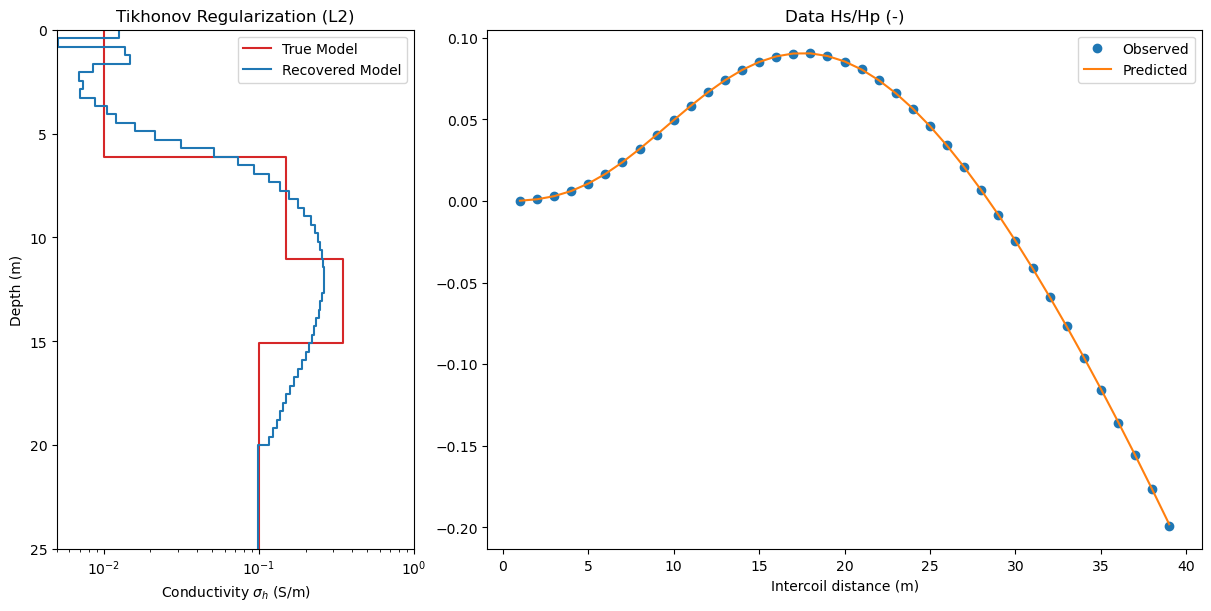

In [7]:
p_mpred = np.repeat(np.exp(x.x), 2)

axs = plt.figure(figsize=(12, 6), constrained_layout=True).subplot_mosaic('ABB;ABB')
ax1, ax2 = axs.values()

# Plot Resistivities
ax1.set_title("Tikhonov Regularization (L2)")
ax1.plot(p_mtrue, p_depth, 'C3', label="True Model")
ax1.plot(p_mpred, p_depth, "-", label="Recovered Model")
ax1.set_xscale('log')
ax1.set_xlim([0.005, 1])
ax1.set_ylim([p_depth[-1], p_depth[0]])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Conductivity $\sigma_h$ (S/m)');
ax1.legend()

# Observed versus predicted data
pred = forward(depth, np.exp(x.x), rec_x, freq)
ax2.set_title("Data Hs/Hp (-)")
ax2.plot(rec_x, dobs, "o", label="Observed")
ax2.plot(rec_x, pred, "-", label="Predicted")
ax2.set_xlabel('Intercoil distance (m)')
ax2.legend();

In [8]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Tue Feb 27 15:58:14 2024 CET

                OS : Linux
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06)
  [GCC 11.3.0]

             numpy : 1.24.4
             scipy : 1.11.1
             numba : 0.57.1
           empymod : 2.2.3.dev7+g0ee2107.d20240223
           IPython : 8.12.0
        matplotlib : 3.7.2

  Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------